<a href="https://colab.research.google.com/github/crislmfroes/tensorflow-colab/blob/master/prevendo_eficiencia_combustiveis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q seaborn

In [0]:
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

In [4]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()

In [0]:
origin = dataset.pop('Origin')

In [9]:
dataset['USA'] = (origin == 1) * 1
dataset['Europe'] = (origin == 2) * 1
dataset['Japan'] = (origin == 3) * 1
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

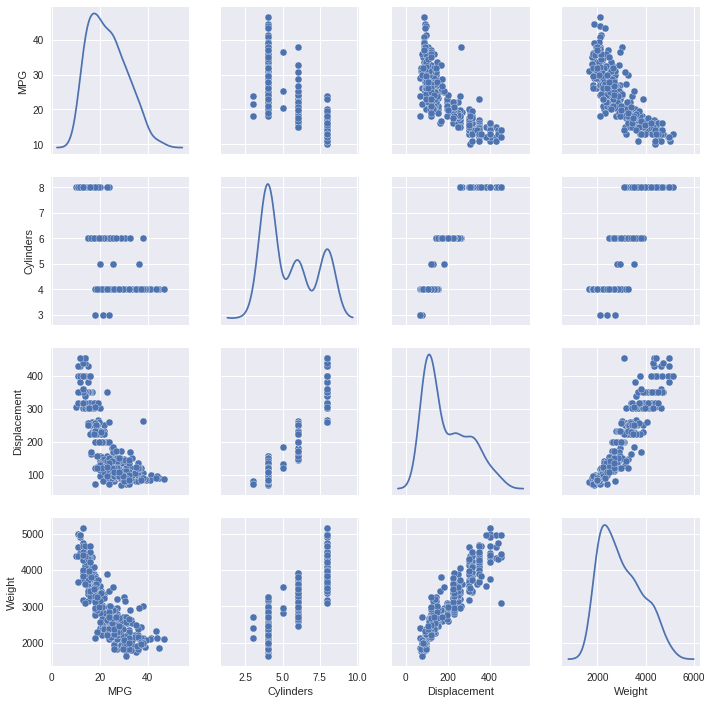

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [12]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

In [0]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
def build_model():
  model = keras.Sequential([
      keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
      keras.layers.Dense(64, activation=tf.nn.relu),
      keras.layers.Dense(1)
  ])
  
  optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)
  
  model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
  
  return model

In [21]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [22]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.270005  ],
       [-0.06024554],
       [-0.00674164],
       [-0.14402322],
       [ 0.04345146],
       [ 0.00545055],
       [ 0.03775693],
       [-0.06199287],
       [ 0.00113745],
       [ 0.14343013]], dtype=float32)

In [0]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [25]:
EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.265909,0.993284,2.265909,9.170109,2.318811,9.170109,995
996,2.223401,0.979329,2.223401,9.164516,2.311662,9.164516,996
997,2.185310,0.932265,2.185310,9.463946,2.381986,9.463946,997
998,2.250993,0.999830,2.250993,9.004914,2.334024,9.004914,998
999,2.432366,0.988885,2.432366,9.141117,2.313738,9.141117,999


In [0]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Val Error')
  plt.legend()
  plt.ylim([0, 5])
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'], label='Val Error')
  plt.legend()
  plt.ylim([0, 20])

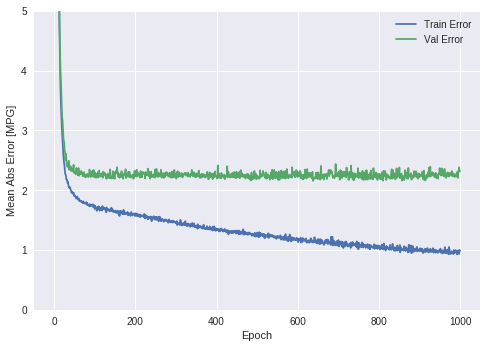

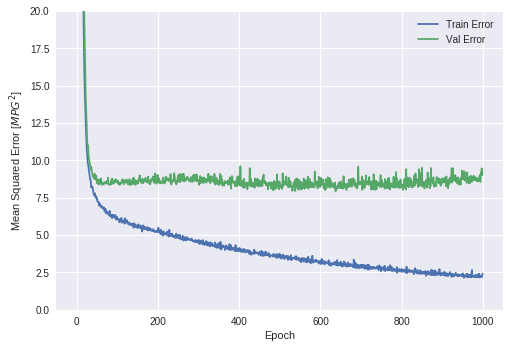

In [33]:
plot_history(history)

In [34]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])


....................................................................................................
..........................................................................

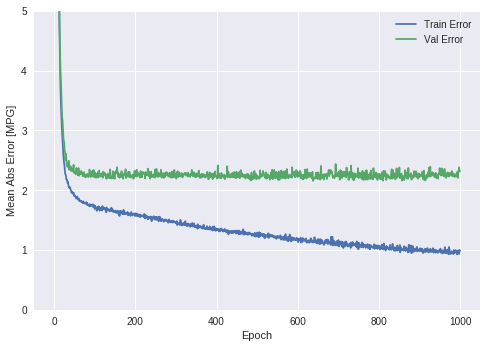

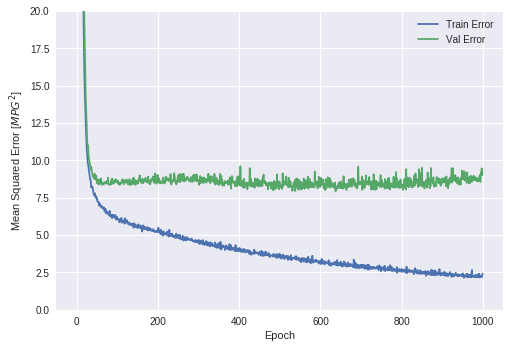

In [35]:
plot_history(history)

In [40]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print(mae)
print("Tenting set Mean Abs Error: {:5.2f} MPG".format(mae))

1.88344083688198
Tenting set Mean Abs Error:  1.88 MPG


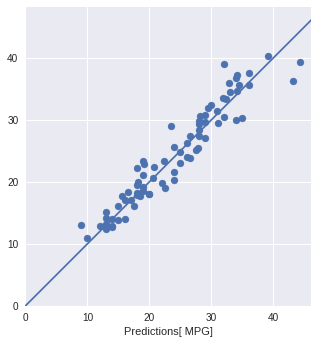

In [41]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.xlabel('Predictions[ MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim(0, plt.xlim()[1])
plt.ylim(0, plt.ylim()[1])

_ = plt.plot([-100, 100], [-100, 100])

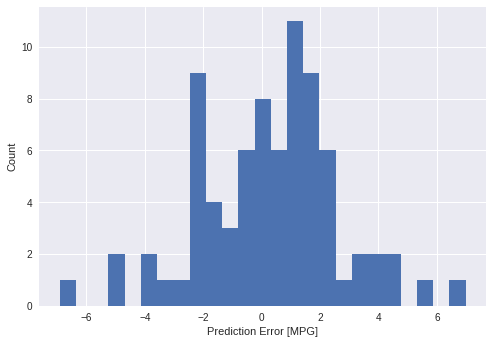

In [42]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [0]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.